**Plan of the work:**

1)take model

2)take default CIFAR100 dataset

3)for fixed n_epochs measure acc after adv training

4)construct dataset from CIFAR100 with following changes:

*   for easy classes - decrease at half their number in dataset 

5)for fixed n_epochs measure acc after adv training

6)compare results from 3 and 5.





In [ ]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
set_seed(42)

#Model

In [ ]:
class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if (stride != 1) or (in_planes != self.expansion * planes):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if (stride != 1) or (in_planes != self.expansion * planes):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.bn = nn.BatchNorm2d(512 * block.expansion)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18(num_classes=10):
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes)

In [ ]:
def prepare_transforms(augments=[True, False]):
    data_mean = (0.5071, 0.4865, 0.4409)
    data_std = (0.2673, 0.2564, 0.2762)
    # types of transform: with augmentation and without
    transform_augmented = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    transform_clean = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)])
    # choose transform according func params
    train_transform = transform_augmented if augments[0] else transform_clean
    test_transform = transform_augmented if augments[1] else transform_clean

    return train_transform, test_transform

def get_loaders(data_dir='cifar-data', batch_size=32, augments=[True, False], shuffles=[True, False]):
    train_transform, test_transform = prepare_transforms(augments)
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(
            data_dir, train=False, transform=test_transform, download=True)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffles[0],
        pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size, shuffle=shuffles[1],
        pin_memory=True, num_workers=2)

    return train_loader, test_loader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PreActResNet18(num_classes=100).to(device)

#Adv training on default dataset

In [ ]:
weight_decay = 5e-4
epsilon = 8
batch_size = 32
alpha = 2
loss_weight = 0.3
fgsm_step = 1
delta_init = 'random'
train_loader, test_loader = get_loaders(augments=[False,False])
model = PreActResNet18(num_classes=100).to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()

data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)

mu = torch.tensor(data_mean).view(3, 1, 1).to(device)
std = torch.tensor(data_std).view(3, 1, 1).to(device)
upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)
epsilon = (epsilon / 255.) / std
alpha = (alpha / 255.) / std

if delta_init == 'previous':
    delta = torch.zeros(batch_size, 3, 32, 32).to(device)

prev_robust_acc = 0.

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

In [ ]:
NUM_CLASSES = 100

def attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=None):

    max_loss = torch.zeros(y.shape[0]).to(device)
    max_delta = torch.zeros_like(X).to(device)
    scaler = torch.cuda.amp.GradScaler()

    for _ in range(restarts):
        delta = torch.zeros_like(X).to(device)
        for i in range(len(epsilon)):
            delta[:, i, :, :].uniform_(-epsilon[i][0][0].item(), epsilon[i][0][0].item())
        delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        delta.requires_grad = True

        for _ in range(attack_iters):
            with torch.cuda.amp.autocast():
                output = model(X + delta)
                index = torch.where(output.max(1)[1] == y)[0]
                if len(index) == 0:
                    break
                loss = F.cross_entropy(output, y)

            scaler.scale(loss).backward()
            grad = delta.grad.detach()

            d = delta[index, :, :, :]
            g = grad[index, :, :, :]
            d = clamp(d + alpha * torch.sign(g), -epsilon, epsilon)
            d = clamp(d, lower_limit - X[index, :, :, :], upper_limit - X[index, :, :, :])

            delta.data[index, :, :, :] = d
            delta.grad.zero_()

        all_loss = F.cross_entropy(model(X + delta), y, reduction='none').detach()
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    return max_delta


def evaluate_pgd(test_loader, model, attack_iters, restarts, epsilon, alpha, lower_limit, upper_limit, args=None):

    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}

    pgd_loss, pgd_acc = 0, 0
    n = 0
    model.eval()
    for i, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)
        pgd_delta = attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, lower_limit, upper_limit, args=args)
        with torch.no_grad():
            output = model(X + pgd_delta)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            pgd_loss += loss.item() * y.size(0)
            pgd_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
        acc_per_class = {}
    for i in range(NUM_CLASSES):
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
    return pgd_loss/n, pgd_acc/n,acc_per_class


def evaluate_standard(test_loader, model, args=None):
    
    examples_per_class = {i : 0 for i in range(NUM_CLASSES)}
    correct_per_class = {i : 0 for i in range(NUM_CLASSES)}
    
    test_loss, test_acc = 0, 0
    n = 0
    model.eval()
    with torch.no_grad():
        for i, (X, y) in tqdm(enumerate(test_loader), total=len(test_loader)):
            X, y = X.to(device), y.to(device)
            output = model(X)
            preds = output.max(1)[1]
            for i in range(NUM_CLASSES):
                examples_per_class[i] += len(y[y==i])
                correct_per_class[i] += (preds[y==i] == i).sum().item()
            loss = F.cross_entropy(output, y)
            test_loss += loss.item() * y.size(0)
            test_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
    acc_per_class = {}
    for i in range(NUM_CLASSES):
        acc_per_class[i] = correct_per_class[i] / examples_per_class[i]
    return test_loss/n, test_acc/n,acc_per_class


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=weight_decay)

epochs = 7
loop = tqdm(range(epochs))
for epoch in loop:
    train_loss,train_acc,train_n = 0,0,0
    # if epoch > 12:
    #   optimizer.param_groups[0]['lr'] = 1e-4
    model.train()
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        if delta_init != 'previous':
            delta = torch.zeros_like(X).to(device)
        if delta_init == 'random':
            for j in range(len(epsilon)):
                delta[:, j, :, :].uniform_(-epsilon[j][0][0].item(), epsilon[j][0][0].item())
            delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        if fgsm_step == 1:
            delta.requires_grad = True
            for _ in range(1):
                output = model(X + delta[:X.size(0)])
                loss = F.cross_entropy(output, y)
                scaler.scale(loss).backward()
                grad = delta.grad.detach()
                scaler.step(optimizer)
                scaler.update()
                delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
                delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
            delta = delta.detach()
            output = model(X + delta[:X.size(0)])
            loss = (1 - loss_weight) * criterion(output, y) + loss_weight * criterion(model(X), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)
      
    model.eval()
    pgd_loss, pgd_acc, acc_cl_pgd_at = evaluate_pgd(test_loader, model, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
    
    if pgd_acc >= 0.4:
      best_state_dict = model.state_dict()
      torch.save(best_state_dict,'model_default_good.pth')
      
    loop.set_description(f'train acc: {round(train_acc / train_n,3)} test acc: {pgd_acc}')

train acc: 0.432 test acc: 0.3382: 100%|██████████| 7/7 [24:12<00:00, 207.51s/it]


In [ ]:
best_state_dict_at = model.state_dict()

torch.save(best_state_dict_at,'model_default_at33.pth')

In [ ]:
# Evaluation
model_at = PreActResNet18(num_classes=100).to(device)
#model_at.load_state_dict(best_state_dict_at)
model_at.load_state_dict(torch.load('model_default_at33.pth'))
model_at.float()
model_at.eval()


pgd_loss, pgd_acc, acc_cl_pgd_at1 = evaluate_pgd(test_loader, model_at, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
print(pgd_acc)
test_loss, test_acc, acc_cl_standart_at1 = evaluate_standard(test_loader, model_at)
print(test_acc)

0.3392


100%|██████████| 313/313 [00:09<00:00, 34.07it/s]

0.5474


#Accuracy and PpC

After 7 epochs - 34%

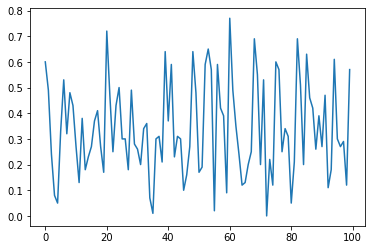

In [ ]:
for_plot = list(acc_cl_pgd_at1.values())

plt.plot(range(100),for_plot)

# Construct modified dataset

In [ ]:
hard_classes = [13,35,55,72,96,10,44,65,74,4]
easy_classes = [8,9,20,87,94,21,41,39,53,68]

In [ ]:
data_dir='cifar-data'
batch_size=32
augments=[True, False]
shuffles=[True, False]
train_transform, test_transform = prepare_transforms(augments)
train_dataset = datasets.CIFAR100(data_dir, train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR100(data_dir, train=False, transform=test_transform, download=True)


test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size, shuffle=shuffles[1],
    pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_transform, test_transform = prepare_transforms(augments=[False,False])

train_dataset = datasets.CIFAR100(data_dir, train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR100(data_dir, train=False, transform=test_transform, download=True)
X_all,y_all = train_dataset.data, torch.LongTensor(train_dataset.targets)

X_all_sampled, y_all_sampled = [], []

for c in torch.unique(y_all):
    X_all_c, y_all_c = X_all[y_all==c], y_all[y_all==c]
    
    if c in easy_classes:
        num_samples = len(X_all_c)
        sampled_indices = torch.randperm(num_samples)[:num_samples//2]
        X_all_sampled.append(X_all_c[sampled_indices])
        y_all_sampled.append(y_all_c[sampled_indices]) 

    else:
        num_samples = len(X_all_c)
        sampled_indices = torch.randperm(num_samples)
        X_all_sampled.append(X_all_c[sampled_indices])
        y_all_sampled.append(y_all_c[sampled_indices]) 
    
X_all_sampled = np.concatenate(X_all_sampled, axis=0)
y_all_sampled = list(torch.cat(y_all_sampled, dim=0).numpy())

X_all_sampled.shape

Files already downloaded and verified
Files already downloaded and verified


(47500, 32, 32, 3)

In [ ]:
def get_train_loader(data_dir, X, y, batch_size, augment=True, shuffle=True, args=None):

    train_transform, _ = prepare_transforms([augment, False])
    train_dataset = datasets.CIFAR100(
            data_dir, train=True, transform=train_transform, download=True
        ) # we don't care what data here, we made it for getting appropriate transform
    train_dataset.data = X
    train_dataset.targets = y

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size, shuffle=shuffle,
        pin_memory=True, num_workers=2,
    )
    return train_loader

In [ ]:
train_loader = get_train_loader(data_dir, X_all_sampled, y_all_sampled,
                    batch_size, augment=False, shuffle=True)

Files already downloaded and verified


# Adv training on modified dataset

In [ ]:
model = PreActResNet18(num_classes=100).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=weight_decay)

epochs = 7
loop = tqdm(range(epochs))
for epoch in loop:
    train_loss,train_acc,train_n = 0,0,0
    if epoch > 12:
      optimizer.param_groups[0]['lr'] = 0.5e-4

    model.train()
    for i, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        if delta_init != 'previous':
            delta = torch.zeros_like(X).to(device)
        if delta_init == 'random':
            for j in range(len(epsilon)):
                delta[:, j, :, :].uniform_(-epsilon[j][0][0].item(), epsilon[j][0][0].item())
            delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        if fgsm_step == 1:
            delta.requires_grad = True
            for _ in range(1):
                output = model(X + delta[:X.size(0)])
                loss = F.cross_entropy(output, y)
                scaler.scale(loss).backward()
                grad = delta.grad.detach()
                scaler.step(optimizer)
                scaler.update()
                delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
                delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
            delta = delta.detach()
            output = model(X + delta[:X.size(0)])
            loss = (1 - loss_weight) * criterion(output, y) + loss_weight * criterion(model(X), y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)
      
    model.eval()
    pgd_loss, pgd_acc, acc_cl_pgd_at = evaluate_pgd(test_loader, model, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
    
    if pgd_acc >= 0.4:
      best_state_dict = model.state_dict()
      torch.save(best_state_dict,'model_default_good.pth')
      
    loop.set_description(f'train acc: {round(train_acc / train_n,3)} test acc: {pgd_acc}')

train acc: 0.42 test acc: 0.3207: 100%|██████████| 7/7 [23:23<00:00, 200.46s/it]


In [ ]:
model.eval()


pgd_loss, pgd_acc, acc_cl_pgd_at2 = evaluate_pgd(test_loader, model, 1, 5, epsilon, alpha, 
                                  lower_limit, upper_limit)
print(pgd_acc)
test_loss, test_acc, acc_cl_standart_at2 = evaluate_standard(test_loader, model)
print(test_acc)

0.3204


100%|██████████| 313/313 [00:09<00:00, 31.61it/s]

0.527


Near the same overall accuracy(32% against 34%) with 5% data reduced.
Time per iteration reduced from 207.5s to 200.5s (~3%)

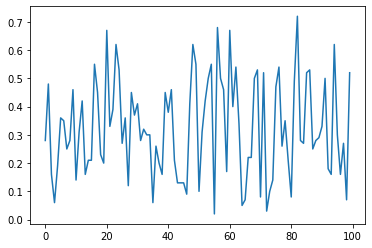

In [ ]:
for_plot = list(acc_cl_pgd_at2.values())

plt.plot(range(100),for_plot)